データサイエンス特別PG データサイエンス特論 第12回 課題

In [ ]:
# google colab で実行する場合は下記のコメントアウトを外して実行する
# ! wget https://github.com/KHiraGit/sudspg_ds/raw/main/ds07_temp_power_exercise.xlsx
# ! pip install japanize-matplotlib

In [22]:
import os
import psutil
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import openpyxl
import pandas as pd
import datetime
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import seaborn as sns

In [24]:
# 論理コア（logical cores）の数を取得し、環境変数に設定
# https://relaxing-living-life.com/1831/
def set_loky_max_cpu_count():
    physical_cores = psutil.cpu_count(logical=False)
    logical_cores = psutil.cpu_count(logical=True)
    cpu_count = max(1, min(physical_cores, logical_cores))
    os.environ['LOKY_MAX_CPU_COUNT'] = str(cpu_count)
    print(f"LOKY_MAX_CPU_COUNT set to {cpu_count}")
set_loky_max_cpu_count()

LOKY_MAX_CPU_COUNT set to 20


In [25]:
weather_df = pd.read_excel('ds07_temp_power_exercise.xlsx', 
                           sheet_name='2020熊谷市気象データ_data', skiprows=[0,1,2],
                           names=['年月日', '平均気温', '', '', '最高気温', '', '', '', '', '最低気温', '', '', '', '', 
                           '降水量', '', '', '', '日照時間', '', '', '', '降雪量', '', '', '', '平均風速', '', '', 
                           '平均蒸気圧', '', '', '平均湿度', '', '', '平均現地気圧', '', '', '', '', '', '天気概況', '', ''])

year = 2020
month = 1
data = ['平均気温', '最高気温', '最低気温', '降水量', '日照時間', '降雪量', '平均風速', '平均蒸気圧', '平均湿度', '平均現地気圧'] 
target = '天気概況'
weather_data = weather_df[(datetime.datetime(year,month,1) <= weather_df['年月日']) 
                        & (weather_df['年月日'] < datetime.datetime(year,month+1,1))][data].values
weather_target = []
for _day, _target in enumerate(weather_df[(datetime.datetime(year,month,1) <= weather_df['年月日']) 
                                          & (weather_df['年月日'] < datetime.datetime(year,month+1,1))][target].values):
    weather_target.append(f'{_target} ({year}/{month}/{_day+1})')
# データを標準化
stdsc = StandardScaler()
weather_data = stdsc.fit_transform(weather_data)

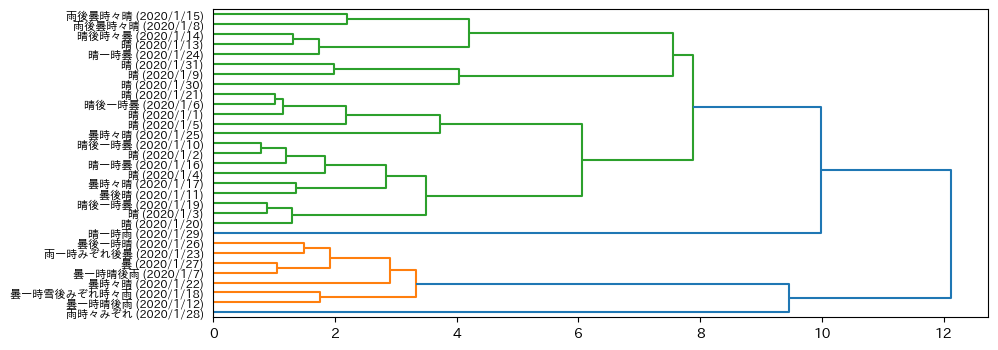

In [26]:
# 階層型クラスタリングのクラスター間の距離を計算 (ユークリッド距離を利用)
dist = hierarchy.distance.pdist(weather_data, metric='euclidean')
# クラスターを統合 (ward法)
linkage = hierarchy.linkage(dist, method='ward', metric='euclidean') 
# デンドログラムを表示
fig, ax = plt.subplots(figsize=(10,4))
ax = hierarchy.dendrogram(Z=linkage, orientation='right', labels=weather_target)

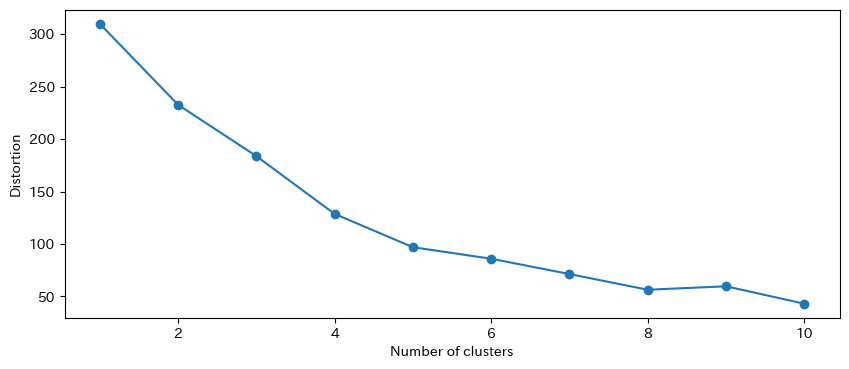

In [27]:
# クラスタ数を決定するために距離の総計を確認
distortions = []
for i  in range(1,11):
    km = KMeans(n_clusters=i, init='random', max_iter=30, random_state=1)
    km.fit(weather_data)
    distortions.append(km.inertia_)

plt.figure(figsize=(10,4))
plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

cluster 0 ['晴 (2020/1/1)', '晴 (2020/1/2)', '晴 (2020/1/3)', '晴 (2020/1/4)', '晴 (2020/1/5)', '晴後一時曇 (2020/1/6)', '晴後一時曇 (2020/1/10)', '曇後晴 (2020/1/11)', '晴一時曇 (2020/1/16)', '曇時々晴 (2020/1/17)', '晴後一時曇 (2020/1/19)', '晴 (2020/1/20)', '晴 (2020/1/21)', '曇時々晴 (2020/1/25)', '晴 (2020/1/31)']
cluster 1 ['雨後曇時々晴 (2020/1/8)', '晴 (2020/1/9)', '晴 (2020/1/13)', '晴後時々曇 (2020/1/14)', '雨後曇時々晴 (2020/1/15)', '晴一時曇 (2020/1/24)', '晴一時雨 (2020/1/29)', '晴 (2020/1/30)']
cluster 2 ['曇一時晴後雨 (2020/1/7)', '曇一時晴後雨 (2020/1/12)', '曇一時雪後みぞれ時々雨 (2020/1/18)', '曇時々晴 (2020/1/22)', '雨一時みぞれ後曇 (2020/1/23)', '曇後一時晴 (2020/1/26)', '曇 (2020/1/27)', '雨時々みぞれ (2020/1/28)']


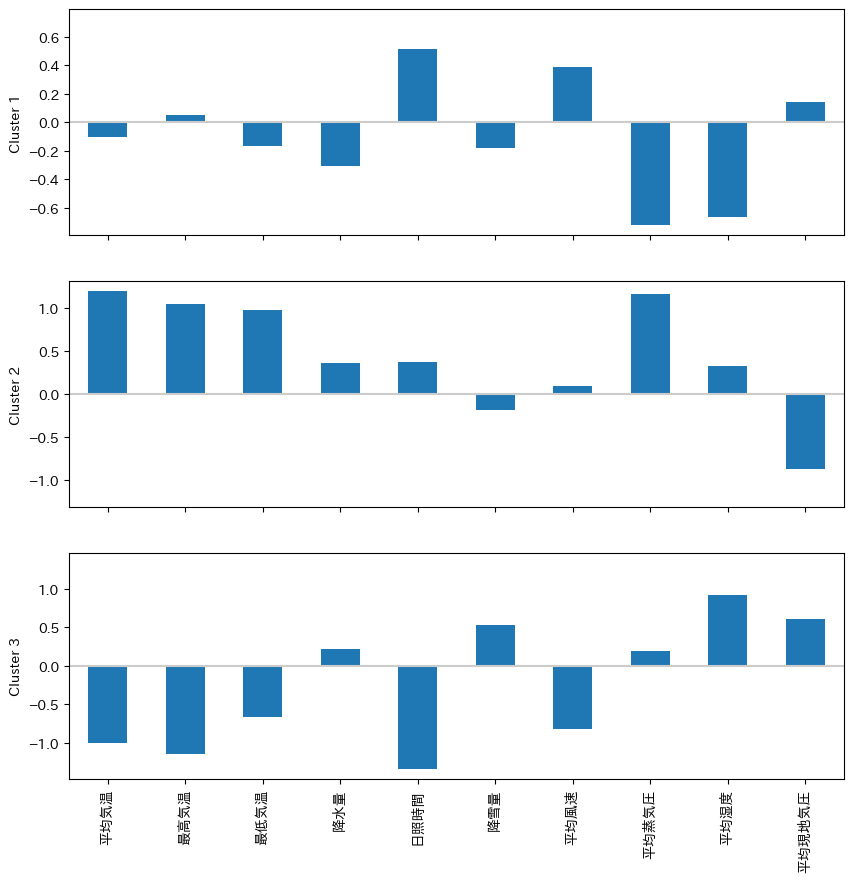

In [28]:
# クラスタ数を決めて、kmeans法でクラスタリング
_n_cluster = 3
kmeans = KMeans(n_clusters=_n_cluster, max_iter=30, init="random", random_state=1)
cluster = kmeans.fit_predict(weather_data)

# 各クラスタの天気概況を確認
for i in range(_n_cluster):
    _weather_list = []
    for _cluster, _weather in zip(cluster, weather_target):
        if i == _cluster:
            _weather_list.append(_weather)
    print('cluster', i, _weather_list)

# 各クラスターの重心を棒グラフで表示
# (データサイエンスのための統計学入門 p316 より)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=data)
f, axes = plt.subplots(_n_cluster, 1, sharex=True, figsize=(10,10))
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.1 * np.max(np.max(np.abs(center)))
    center.plot.bar(ax=ax)
    ax.axhline(color='#cccccc')
    ax.set_ylabel(f'Cluster {i+1}')
    ax.set_ylim(-maxPC, maxPC)

cluster 0 ['晴 (2020/1/1)', '晴 (2020/1/4)', '晴 (2020/1/5)', '晴後一時曇 (2020/1/6)', '晴一時曇 (2020/1/16)', '晴 (2020/1/21)', '曇時々晴 (2020/1/25)', '晴 (2020/1/31)']
cluster 1 ['晴 (2020/1/2)', '晴 (2020/1/3)', '晴 (2020/1/9)', '晴後一時曇 (2020/1/10)', '晴 (2020/1/13)', '晴後時々曇 (2020/1/14)', '晴後一時曇 (2020/1/19)', '晴 (2020/1/20)', '晴一時曇 (2020/1/24)', '晴一時雨 (2020/1/29)', '晴 (2020/1/30)']
cluster 2 ['曇一時晴後雨 (2020/1/7)', '雨後曇時々晴 (2020/1/8)', '曇後晴 (2020/1/11)', '曇一時晴後雨 (2020/1/12)', '雨後曇時々晴 (2020/1/15)', '曇時々晴 (2020/1/17)', '曇一時雪後みぞれ時々雨 (2020/1/18)', '曇時々晴 (2020/1/22)', '雨一時みぞれ後曇 (2020/1/23)', '曇後一時晴 (2020/1/26)', '曇 (2020/1/27)', '雨時々みぞれ (2020/1/28)']


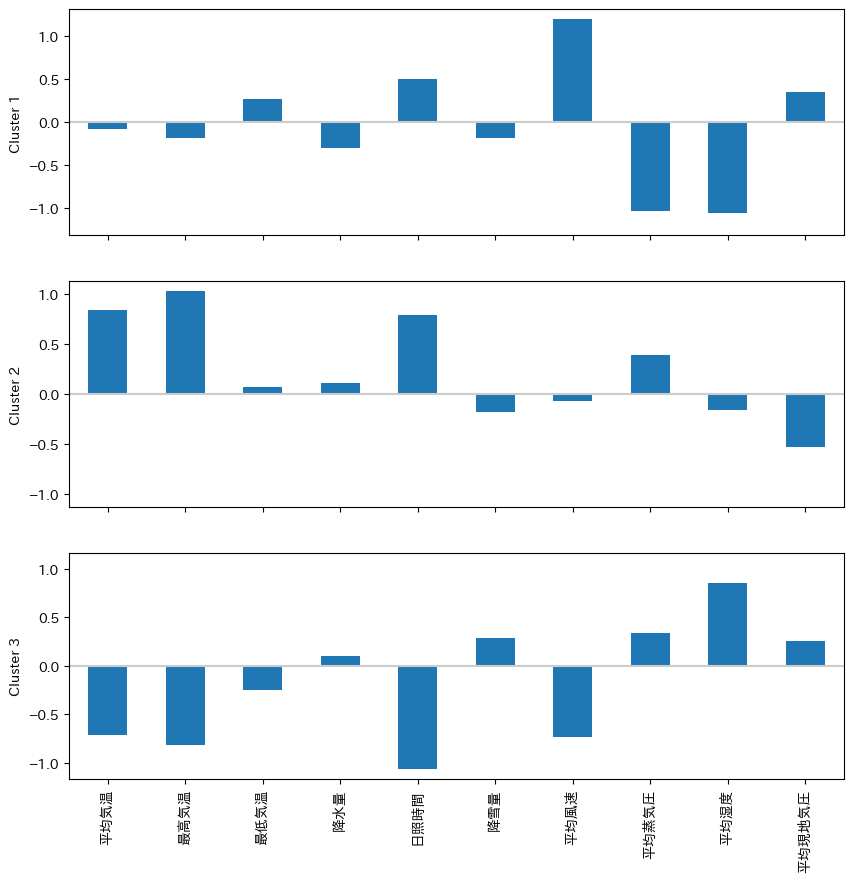

In [29]:
# 混合カウスモデルでクラスタリングを実行
_n_cluster = 3
clf = GaussianMixture(n_components=_n_cluster)
cluster = clf.fit_predict(weather_data)

# 各クラスタの天気概況を確認
for i in range(_n_cluster):
    _weather_list = []
    for _cluster, _weather in zip(cluster, weather_target):
        if i == _cluster:
            _weather_list.append(_weather)
    print('cluster', i, _weather_list)

# 各クラスターの重心を棒グラフで表示
# (データサイエンスのための統計学入門 p316 より)
centers = pd.DataFrame(clf.means_, columns=data)
f, axes = plt.subplots(_n_cluster, 1, sharex=True, figsize=(10,10))
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.1 * np.max(np.max(np.abs(center)))
    center.plot.bar(ax=ax)
    ax.axhline(color='#cccccc')
    ax.set_ylabel(f'Cluster {i+1}')
    ax.set_ylim(-maxPC, maxPC)